# Notebook 1 - ETL i Anàlisi Exploratòria de Dades (EDA)

Aquest notebook executa el pipeline complet d'extracció, transformació i càrrega (ETL) de dades de jugadors de bàsquet de la FEB. Inclou:

- Connexió a MongoDB i càrrega de dades estadístiques
- Execució del pipeline ETL amb neteja, agregació i generació de mètriques avançades
- Anàlisi exploratòria: distribucions, outliers, correlacions i validació de qualitat
- Justificació de variables seleccionades per al model de clustering

## 1. Imports i Configuració

Importa les llibreries necessàries (pandas, numpy, matplotlib, seaborn) i els mòduls del projecte (pipeline ETL, configuració, client MongoDB). Configura l'entorn de visualització i carrega els paràmetres principals del projecte (temporada, competició, llindars de filtratge).

In [1]:
# Importar mòduls necessaris
import sys
import os
from pathlib import Path
import importlib

# Llibreries per anàlisi i visualització
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estil de visualització
plt.style.use('default')
sns.set_palette("husl")

# Afegir el directori arrel del projecte al sys.path
parent = str(Path(os.getcwd()).parent)
if parent not in sys.path:
    sys.path.insert(0, parent)

# Recarregar mòduls per capturar canvis en desenvolupament
import src.config
import src.database.mongo_client
import src.data_processing.data_loader
import src.data_processing.data_cleaner
import src.data_processing.feature_engineer
import src.data_processing.data_aggregator
import src.preprocessing.scaler
import src.pipeline.etl_pipeline

importlib.reload(src.config)
importlib.reload(src.database.mongo_client)
importlib.reload(src.data_processing.data_loader)
importlib.reload(src.data_processing.data_cleaner)
importlib.reload(src.data_processing.feature_engineer)
importlib.reload(src.data_processing.data_aggregator)
importlib.reload(src.preprocessing.scaler)
importlib.reload(src.pipeline.etl_pipeline)

from src.pipeline.etl_pipeline import ETLPipeline
from src.config import (
    MONGO_URI, DB_NAME, DEFAULT_SEASON, DEFAULT_COMPETITION,
    MIN_GAMES_THRESHOLD, MIN_MINUTES_THRESHOLD, PROCESSED_DATA_DIR
)

print("Mòduls carregats i recarregats correctament")
print(f"    MongoDB URI: {MONGO_URI}")
print(f"    Base de dades: {DB_NAME}")
print(f"    Temporada per defecte: {DEFAULT_SEASON}")
print(f"    Competició per defecte: {DEFAULT_COMPETITION}")

Mòduls carregats i recarregats correctament
    MongoDB URI: mongodb://localhost:27017/
    Base de dades: feb_db
    Temporada per defecte: 2024-2025
    Competició per defecte: Liga EBA


## 2. Connexió a MongoDB

Inicialitza el pipeline ETL i estableix la connexió amb la base de dades MongoDB. Verifica que la connexió sigui exitosa i mostra les col·leccions disponibles per assegurar l'accés correcte a les dades.

In [2]:
# Inicialitzar pipeline ETL (tota la lògica està als mòduls)
print("\n" + "="*60)
print("CONNEXIO A MONGODB")
print("="*60)

pipeline = ETLPipeline(mongo_uri=MONGO_URI, db_name=DB_NAME)

# Connexió a MongoDB
if pipeline.connect_database():
    print("Connexió exitosa a MongoDB")
    
    # Mostrar col·leccions disponibles
    collections = pipeline.mongo_client.list_collections()
    print(f"Col·leccions disponibles: {collections}")
else:
    raise ConnectionError("[ERROR] Error connectant a MongoDB")


CONNEXIO A MONGODB
Connexió exitosa a MongoDB
Col·leccions disponibles: ['system.views', 'partits', 'jugadors', 'FEB3_players_shots', 'FEB3_teams_statistics', 'FEB3_players_statistics']


## 3. Exploració Inicial de Dades

Consulta el nombre de documents a cada col·lecció (estadístiques de jugadors, equips i tirs) per obtenir una visió general del volum de dades disponibles. Mostra un document d'exemple per entendre l'estructura interna de les dades.

In [3]:
# Exploració de dades disponibles
print("\n" + "="*60)
print("EXPLORACIO INICIAL DE DADES")
print("="*60)

# Accedir a les col·leccions mitjançant el client del pipeline
players_stats = pipeline.mongo_client.db['FEB3_players_statistics']
teams_stats = pipeline.mongo_client.db['FEB3_teams_statistics']
players_shots = pipeline.mongo_client.db['FEB3_players_shots']

print(f"Estadístiques de Jugadors: {players_stats.count_documents({}):,} documents")
print(f"Estadístiques d'Equips: {teams_stats.count_documents({}):,} documents")
print(f"Tirs de Jugadors: {players_shots.count_documents({}):,} documents")


EXPLORACIO INICIAL DE DADES
Estadístiques de Jugadors: 203,913 documents
Estadístiques d'Equips: 17,933 documents
Tirs de Jugadors: 1,170,944 documents


Mostra un document d'exemple de la col·lecció d'estadístiques de jugadors per comprendre l'estructura i els camps disponibles.

In [4]:
# Exemple de document (exploració)
sample_player = players_stats.find_one()
print("\nDocument de jugador (primers 10 camps):\n")
for key, value in list(sample_player.items())[:10]:
    print(f"  {key}: {value}")
print("  ... (més camps disponibles)")


Document de jugador (primers 10 camps):

  match_feb_id: 2487031
  competition_feb_id: 3
  competition_name: Liga EBA
  data: 04-10-2025
  hora: 18:00
  phase_feb_id: 88882
  phase_feb_name: Liga Regular "A-A"
  round_feb_id: 662643
  round_feb_name1: Jornada 1(05/10/2025)
  round_feb_name2: None
  ... (més camps disponibles)


## 4. Filtrat de Dades

Consulta les temporades i competicions disponibles a la base de dades MongoDB per identificar les opcions de filtratge. Mostra els filtres seleccionats (temporada, competició, llindars de partits i minuts) que s'aplicaran a l'extracció de dades.

In [5]:
# Veure temporades i competicions disponibles
print("\n" + "="*60)
print("TEMPORADES I COMPETICIONS DISPONIBLES")
print("="*60)

seasons = sorted(players_stats.distinct('season_id'))
competitions = sorted(players_stats.distinct('competition_name'))

print(f"\nTemporades disponibles ({len(seasons)}):")
for season in seasons:
    print(f"  - {season}")

print(f"\nCompeticions disponibles ({len(competitions)}):")
for comp in competitions:
    print(f"  - {comp}")


TEMPORADES I COMPETICIONS DISPONIBLES

Temporades disponibles (6):
  - 2020-2021
  - 2021-2022
  - 2022-2023
  - 2023-2024
  - 2024-2025
  - 2025

Competicions disponibles (10):
  - LIGA EBA
  - LIGA EBA - E - DESCENSO - 2 - N° JOR: 06 -
  - LIGA EBA - E - DESCENSO - N°JOR: 11 -
  - LIGA EBA - E - FASE REGULAR A - N° JOR: 05
  - LIGA EBA - GRUPO E-A - N° JOR: 08 -
  - LIGA EBA - LIGA REGULAR - E-A - N°JOR: 10 -
  - LIGA EBA - LIGA REGULAR - E-A - N°JOR: 18 -
  - LIGA EBA LIGA REGULAR - E - A - N° JOR: 11 -
  - LIGA EBA LIGA REGULAR-E-A-N°JOR:07-
  - Liga EBA


Defineix i mostra els filtres que s'aplicaran durant l'extracció de dades: temporada, competició i llindars mínims de partits i minuts jugats.

In [6]:
# Especificar filtres (podem canviar-los aquí)
SEASON = DEFAULT_SEASON  # Definit a config.py
COMPETITION = DEFAULT_COMPETITION  # Definit a config.py

print("\n" + "="*60)
print("FILTRES SELECCIONATS")
print("="*60)
print(f"  Temporada:     {SEASON}")
print(f"  Competició:    {COMPETITION}")
print(f"  Mínim partits: {MIN_GAMES_THRESHOLD}")
print(f"  Mínim minuts:  {MIN_MINUTES_THRESHOLD}")


FILTRES SELECCIONATS
  Temporada:     2024-2025
  Competició:    Liga EBA
  Mínim partits: 5
  Mínim minuts:  0


## 5. Executar Pipeline Complet d'ETL

Executa tot el pipeline ETL d'un sol cop: extracció de dades de MongoDB, neteja, agregació per jugador, generació de mètriques avançades (OER, DER, TS%) i normalització de variables. Genera tres datasets: raw (sense normalitzar), scaled (normalitzat) i full_data (complet amb tota la informació).

In [7]:
# Executar pipeline complet (UNA SOLA LÍNIA!)
print("\n" + "="*60)
print("EXECUTANT PIPELINE COMPLET D'ETL")
print("="*60)
print("Extracció, transformació i càrrega en procés...\n")

results = pipeline.run(season=SEASON, competition=COMPETITION)

# Obtenir els resultats
df_raw = results['features_raw']
df_scaled = results['features_scaled']
df_full = results['full_data']

print("\n" + "="*60)
print("PIPELINE COMPLETAT EXITOSAMENT")
print("="*60)
print(f"Jugadors processats: {len(df_scaled)}")
print(f"Features generades: {len(df_raw.columns)}")
print(f"Forma dataset raw: {df_raw.shape}")
print(f"Forma dataset scaled: {df_scaled.shape}")



EXECUTANT PIPELINE COMPLET D'ETL
Extracció, transformació i càrrega en procés...


PIPELINE COMPLETAT EXITOSAMENT
Jugadors processats: 1816
Features generades: 20
Forma dataset raw: (1816, 20)
Forma dataset scaled: (1816, 20)


Inspecció del dataset raw (abans de normalització): mostra la forma, columnes i estadístiques descriptives bàsiques per detectar valors extrems o inconsistències.

In [8]:
# Inspecció del dataset RAW (abans de normalització)
print("INFORMACIÓ DEL DATASET RAW")
print("="*60)
print(f"\nForma: {df_raw.shape}")
print(f"\nColumnes ({len(df_raw.columns)}):")
print(df_raw.columns.tolist())

print("\n" + "="*60)
print("ESTADÍSTIQUES DESCRIPTIVES")
print("="*60)
df_raw.describe().round(3)

INFORMACIÓ DEL DATASET RAW

Forma: (1816, 20)

Columnes (20):
['pts_per36', 'ast_per36', 'trb_per36', 'stl_per36', 'blk_per36', 'tov_per36', 'fga_per36', '3pa_per36', '2pa_per36', 'fg2_pct', 'fg3_pct', 'ft_pct', 'usage_2p', 'usage_3p', 'oer', 'der', 'true_shooting_pct', 'orb', 'drb', 'pf']

ESTADÍSTIQUES DESCRIPTIVES


,pts_per36,ast_per36,trb_per36,stl_per36,blk_per36,tov_per36,fga_per36,3pa_per36,2pa_per36,fg2_pct,fg3_pct,ft_pct,usage_2p,usage_3p,oer,der,true_shooting_pct,orb,drb,pf
count,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000
mean,12.301,2.317,6.420,1.471,0.301,2.661,11.142,4.501,6.640,0.411,0.199,0.363,0.570,0.381,92.370,94.707,0.460,1.098,2.636,1.998
std,4.749,1.411,2.946,0.739,0.413,1.120,3.470,3.055,3.038,0.138,0.121,0.196,0.228,0.225,29.233,6.640,0.109,0.802,1.608,0.695
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,67.959,0.000,0.000,0.000,0.000
25%,8.852,1.308,4.188,0.983,0.000,1.950,8.801,2.063,4.414,0.344,0.104,0.221,0.409,0.211,77.613,90.963,0.414,0.507,1.426,1.517
50%,12.359,2.055,5.979,1.397,0.155,2.570,11.186,4.279,6.445,0.434,0.219,0.365,0.565,0.389,91.990,94.456,0.476,0.883,2.363,2.007
75%,15.500,3.111,8.315,1.940,0.416,3.260,13.569,6.567,8.674,0.503,0.290,0.510,0.740,0.547,106.942,98.587,0.530,1.515,3.575,2.482
max,36.479,8.268,18.656,5.355,3.371,8.795,25.340,24.733,18.565,0.950,0.598,0.873,1.000,0.917,264.842,129.544,0.851,5.090,9.433,4.132


## 6. Anàlisi Exploratòria de Dades (EDA)

Verifica la qualitat del dataset comprovant la presència de valors nuls o infinits. Confirma que el pipeline ha tractat correctament aquests casos abans de continuar amb l'anàlisi.

In [9]:
# Verificar valors nuls (haurien d'estar tractats pel pipeline)
null_counts = df_raw.isnull().sum()
if null_counts.sum() > 0:
    print("Hi ha valors nuls!")
    print(df_raw.isnull().sum()[df_raw.isnull().sum() > 0])
else:
    print("No hi ha valors nuls - Dataset net!")

# Verificar valors infinits
inf_mask = np.isinf(df_raw.select_dtypes(include=[np.number]))
if inf_mask.any().any():
    print("Hi ha valors infinits!")
else:
    print("No hi ha valors infinits - Dataset net!")

No hi ha valors nuls - Dataset net!
No hi ha valors infinits - Dataset net!


### 6.1. Anàlisi de Variables Clau

Mostra els TOP 10 jugadors segons mètriques clau (punts, assistències, rebots, OER, True Shooting %) per identificar els jugadors destacats abans d'aplicar clustering.

In [10]:
# Top 10 jugadors per diferents mètriques
print("TOP 10 JUGADORS PER MÈTRIQUES CLAU")
print("="*60)

metrics = {
    'pts_per36': 'Punts per 36 min',
    'ast_per36': 'Assistències per 36 min',
    'trb_per36': 'Rebots per 36 min',
    'oer': 'Offensive Efficiency Rating',
    'true_shooting_pct': 'True Shooting %'
}

for metric, name in metrics.items():
    if metric in df_full.columns:
        print(f"\n{name}:")
        top_players = df_full.nlargest(5, metric)[['player_name', metric]]
        for idx, (_, row) in enumerate(top_players.iterrows(), 1):
            print(f"  {idx}. {row['player_name']}: {row[metric]:.2f}")

TOP 10 JUGADORS PER MÈTRIQUES CLAU

Punts per 36 min:
  1. P. TORRENS RIERA: 36.48
  2. N. BURJEL: 30.94
  3. D. MILLS NALES: 29.51
  4. A. BLANCO CARDONA: 28.40
  5. C. HERNÁNDEZ MARTÍN: 26.23

Assistències per 36 min:
  1. P. CAMÍ GALERA: 8.27
  2. X. GUIA HORMIGON: 8.21
  3. F. RUESGA MORALES: 7.90
  4. C. NOGUEROL BARRENECHEA: 7.59
  5. E. ZUSTOVICH: 7.48

Rebots per 36 min:
  1. T. SAGNA: 18.66
  2. R. MATOS DISLA: 17.31
  3. R. SANCHES CARDOSO MENDES: 17.17
  4. D. JUZBASIC: 16.58
  5. A. RIBERA MARTINEZ: 16.45

Offensive Efficiency Rating:
  1. J. MORENO POZA: 264.84
  2. J. BEDIA FERRER: 243.19
  3. I. SOLER VALENZUELA: 221.09
  4. C. MORTELLARO: 218.92
  5. M. NDIAYE SOW: 214.31

True Shooting %:
  1. D. ROURE OBIOLS: 0.85
  2. D. GONZALEZ MARIN: 0.83
  3. H. CARRON GRILLO: 0.78
  4. C. HERNÁNDEZ MARTÍN: 0.76
  5. A. RODRIGUEZ VILLEGAS: 0.75


### 6.2. Estadístiques Descriptives

Calcula i mostra estadístiques descriptives completes (mitjana, mediana, desviació estàndard, min, max, quartils) per a totes les variables del dataset.

In [11]:
# Detectar outliers amb mètode IQR per variables clau
def detect_outliers_iqr(df, column):
    """Detecta outliers utilitzant mètode IQR"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("DETECCIO D'OUTLIERS (Metode IQR)")
print("="*60)

key_metrics = ['pts_per36', 'ast_per36', 'trb_per36', 'oer', 'true_shooting_pct']
for metric in key_metrics:
    if metric in df_raw.columns:
        outliers, lb, ub = detect_outliers_iqr(df_raw, metric)
        pct = (len(outliers) / len(df_raw)) * 100
        print(f"\n{metric}:")
        print(f"  Rang normal: [{lb:.2f}, {ub:.2f}]")
        print(f"  Outliers: {len(outliers)} ({pct:.1f}%)")

DETECCIO D'OUTLIERS (Metode IQR)

pts_per36:
  Rang normal: [-1.12, 25.47]
  Outliers: 5 (0.3%)

ast_per36:
  Rang normal: [-1.40, 5.81]
  Outliers: 41 (2.3%)

trb_per36:
  Rang normal: [-2.00, 14.51]
  Outliers: 22 (1.2%)

oer:
  Rang normal: [33.62, 150.94]
  Outliers: 108 (5.9%)

true_shooting_pct:
  Rang normal: [0.24, 0.71]
  Outliers: 90 (5.0%)


### 6.3. Distribucions de Variables

Genera histogrames per a cada variable numèrica del dataset per visualitzar les distribucions, detectar asimetries (skewness) i identificar possibles outliers o patrons particulars.

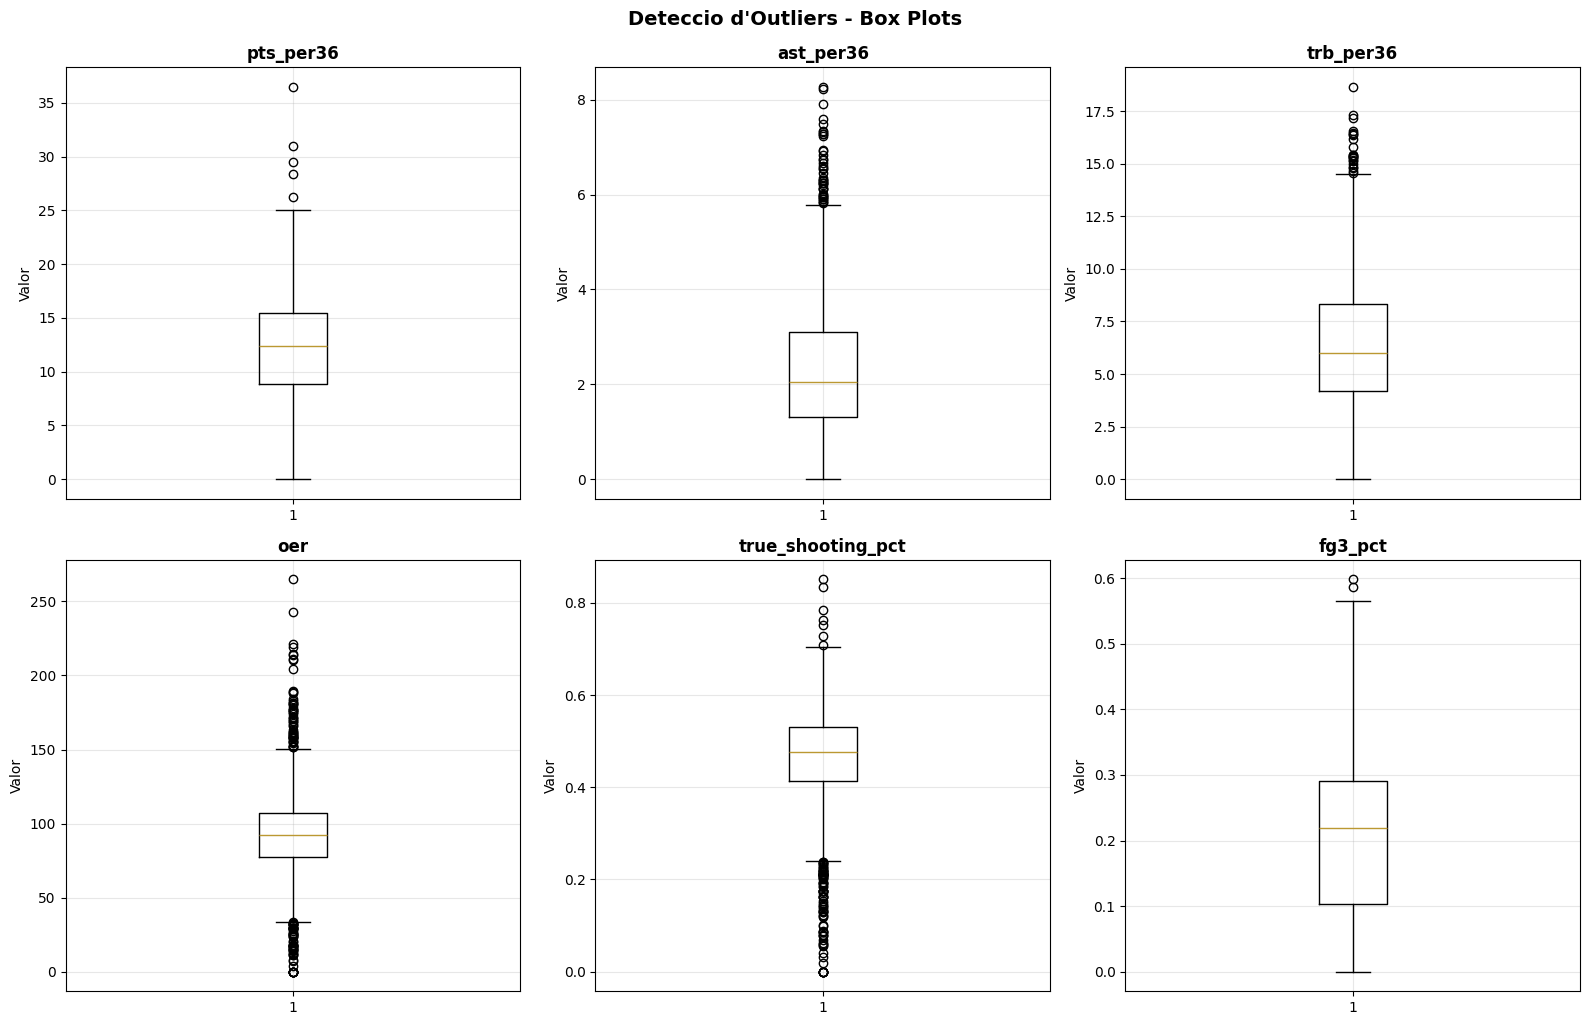

In [12]:
# Box plots per detectar outliers
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

box_metrics = ['pts_per36', 'ast_per36', 'trb_per36', 'oer', 'true_shooting_pct', 'fg3_pct']

for i, metric in enumerate(box_metrics):
    if metric in df_raw.columns:
        axes[i].boxplot(df_raw[metric].dropna(), vert=True)
        axes[i].set_title(f'{metric}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Valor')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Deteccio d\'Outliers - Box Plots', fontsize=14, fontweight='bold', y=1.02)
plt.show()

### 6.4. Box Plots per Detecció d'Outliers

Crea box plots per a cada variable numèrica per identificar visualment outliers utilitzant el mètode IQR (Interquartile Range). Permet detectar valors extrems i decidir si són vàlids o errors de dades.

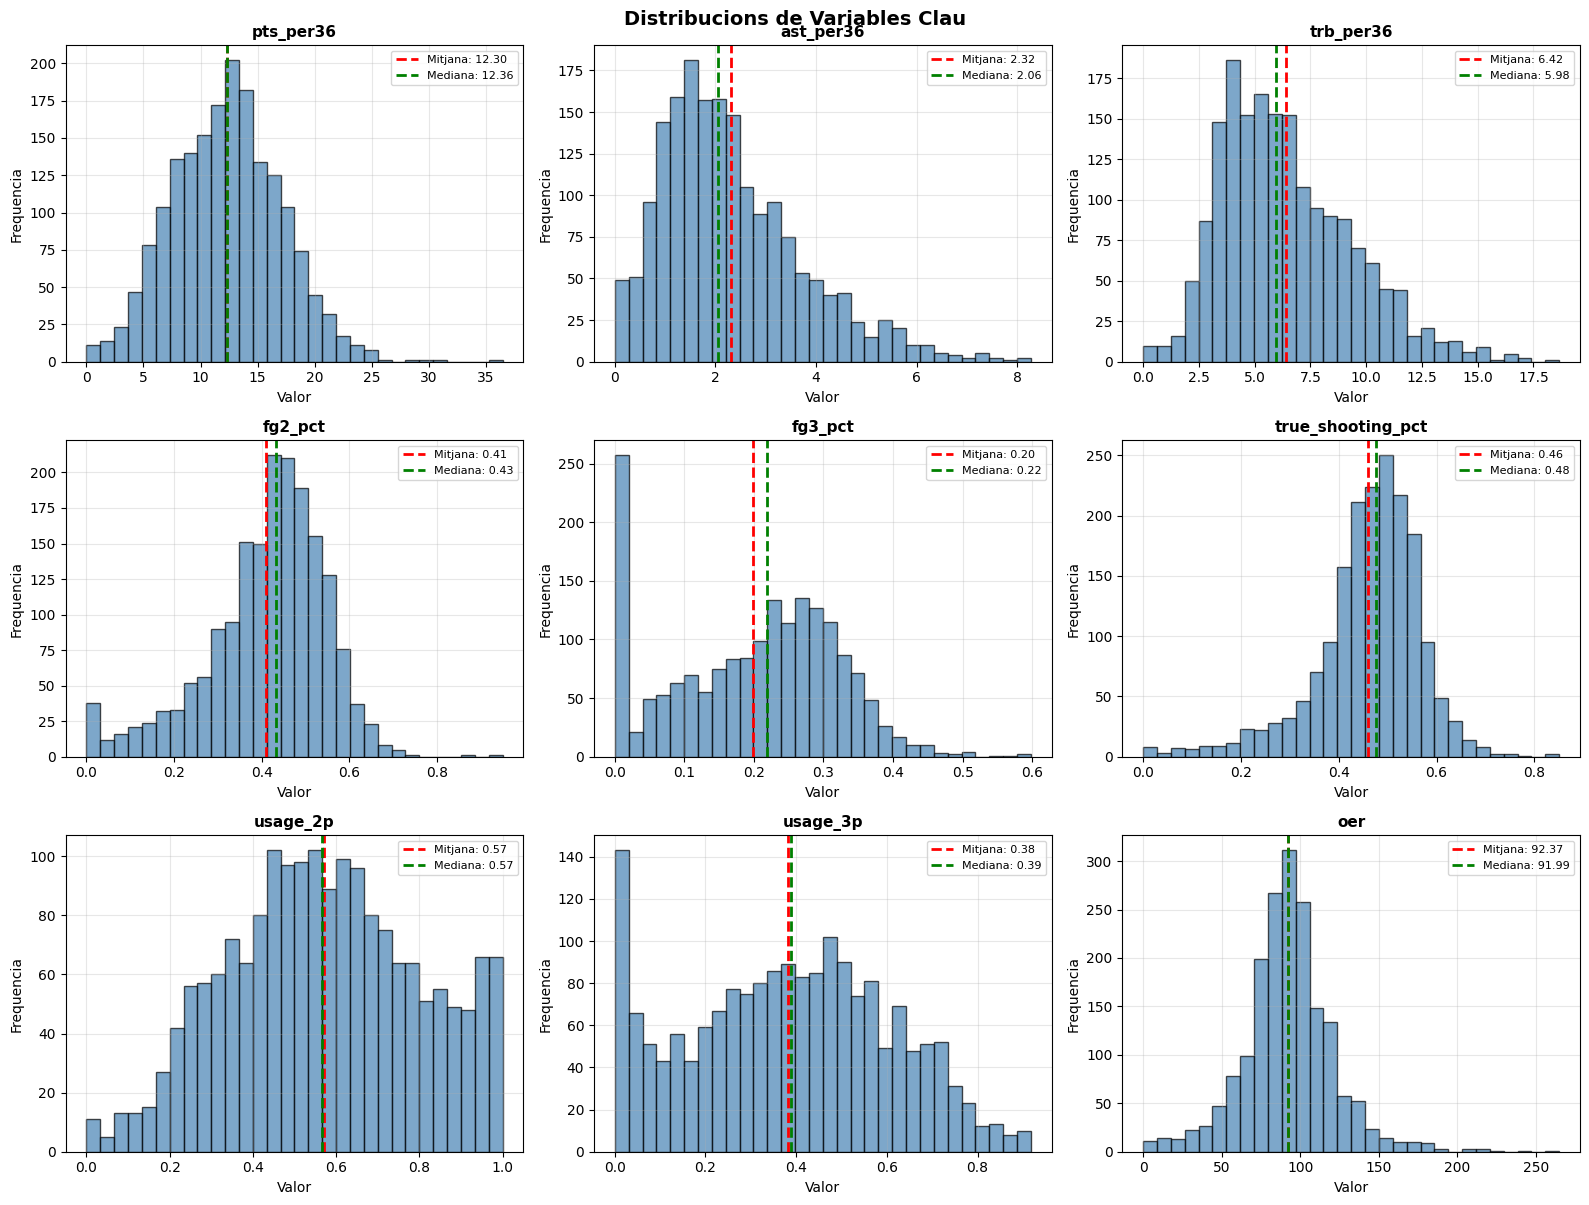

In [13]:
# Histogrames de distribució
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

dist_metrics = [
    'pts_per36', 'ast_per36', 'trb_per36', 
    'fg2_pct', 'fg3_pct', 'true_shooting_pct',
    'usage_2p', 'usage_3p', 'oer'
]

for i, metric in enumerate(dist_metrics):
    if metric in df_raw.columns:
        data = df_raw[metric].dropna()
        
        axes[i].hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        axes[i].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mitjana: {data.mean():.2f}')
        axes[i].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {data.median():.2f}')
        
        axes[i].set_title(metric, fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Valor')
        axes[i].set_ylabel('Frequencia')
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribucions de Variables Clau', fontsize=14, fontweight='bold', y=1.00)
plt.show()

### 6.5. Anàlisi d'Outliers (Mètode IQR)

Aplica el mètode IQR (Interquartile Range) per detectar outliers en variables clau. Mostra el nombre d'outliers per variable i proporciona un resum estadístic dels valors extrems detectats.

In [14]:
# Identificar correlacions fortes
correlation_matrix = df_raw.corr()

# Trobar parelles amb |correlació| > 0.7
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            strong_corr.append({
                'Variable 1': correlation_matrix.columns[i],
                'Variable 2': correlation_matrix.columns[j],
                'Correlació': corr_val
            })

print("CORRELACIONS FORTES (|r| > 0.7)")
print("="*60)
if strong_corr:
    df_corr = pd.DataFrame(strong_corr).sort_values('Correlació', key=abs, ascending=False)
    for _, row in df_corr.head(15).iterrows():
        print(f"{row['Variable 1']:20s} <-> {row['Variable 2']:20s} : {row['Correlació']:6.3f}")
else:
    print("No s'han trobat correlacions fortes")

CORRELACIONS FORTES (|r| > 0.7)
usage_2p             <-> usage_3p             : -0.880
3pa_per36            <-> usage_3p             :  0.876
pts_per36            <-> fga_per36            :  0.848
trb_per36            <-> orb                  :  0.826
2pa_per36            <-> usage_2p             :  0.790
oer                  <-> true_shooting_pct    :  0.775
trb_per36            <-> drb                  :  0.750
3pa_per36            <-> usage_2p             : -0.741
pts_per36            <-> ft_pct               :  0.718
fg2_pct              <-> true_shooting_pct    :  0.717
orb                  <-> drb                  :  0.706


### 6.6. Matriu de Correlacions

Calcula i visualitza la matriu de correlacions entre totes les variables numèriques del dataset. Utilitza un heatmap amb colors per identificar correlacions fortes (positives o negatives) entre parelles de variables.

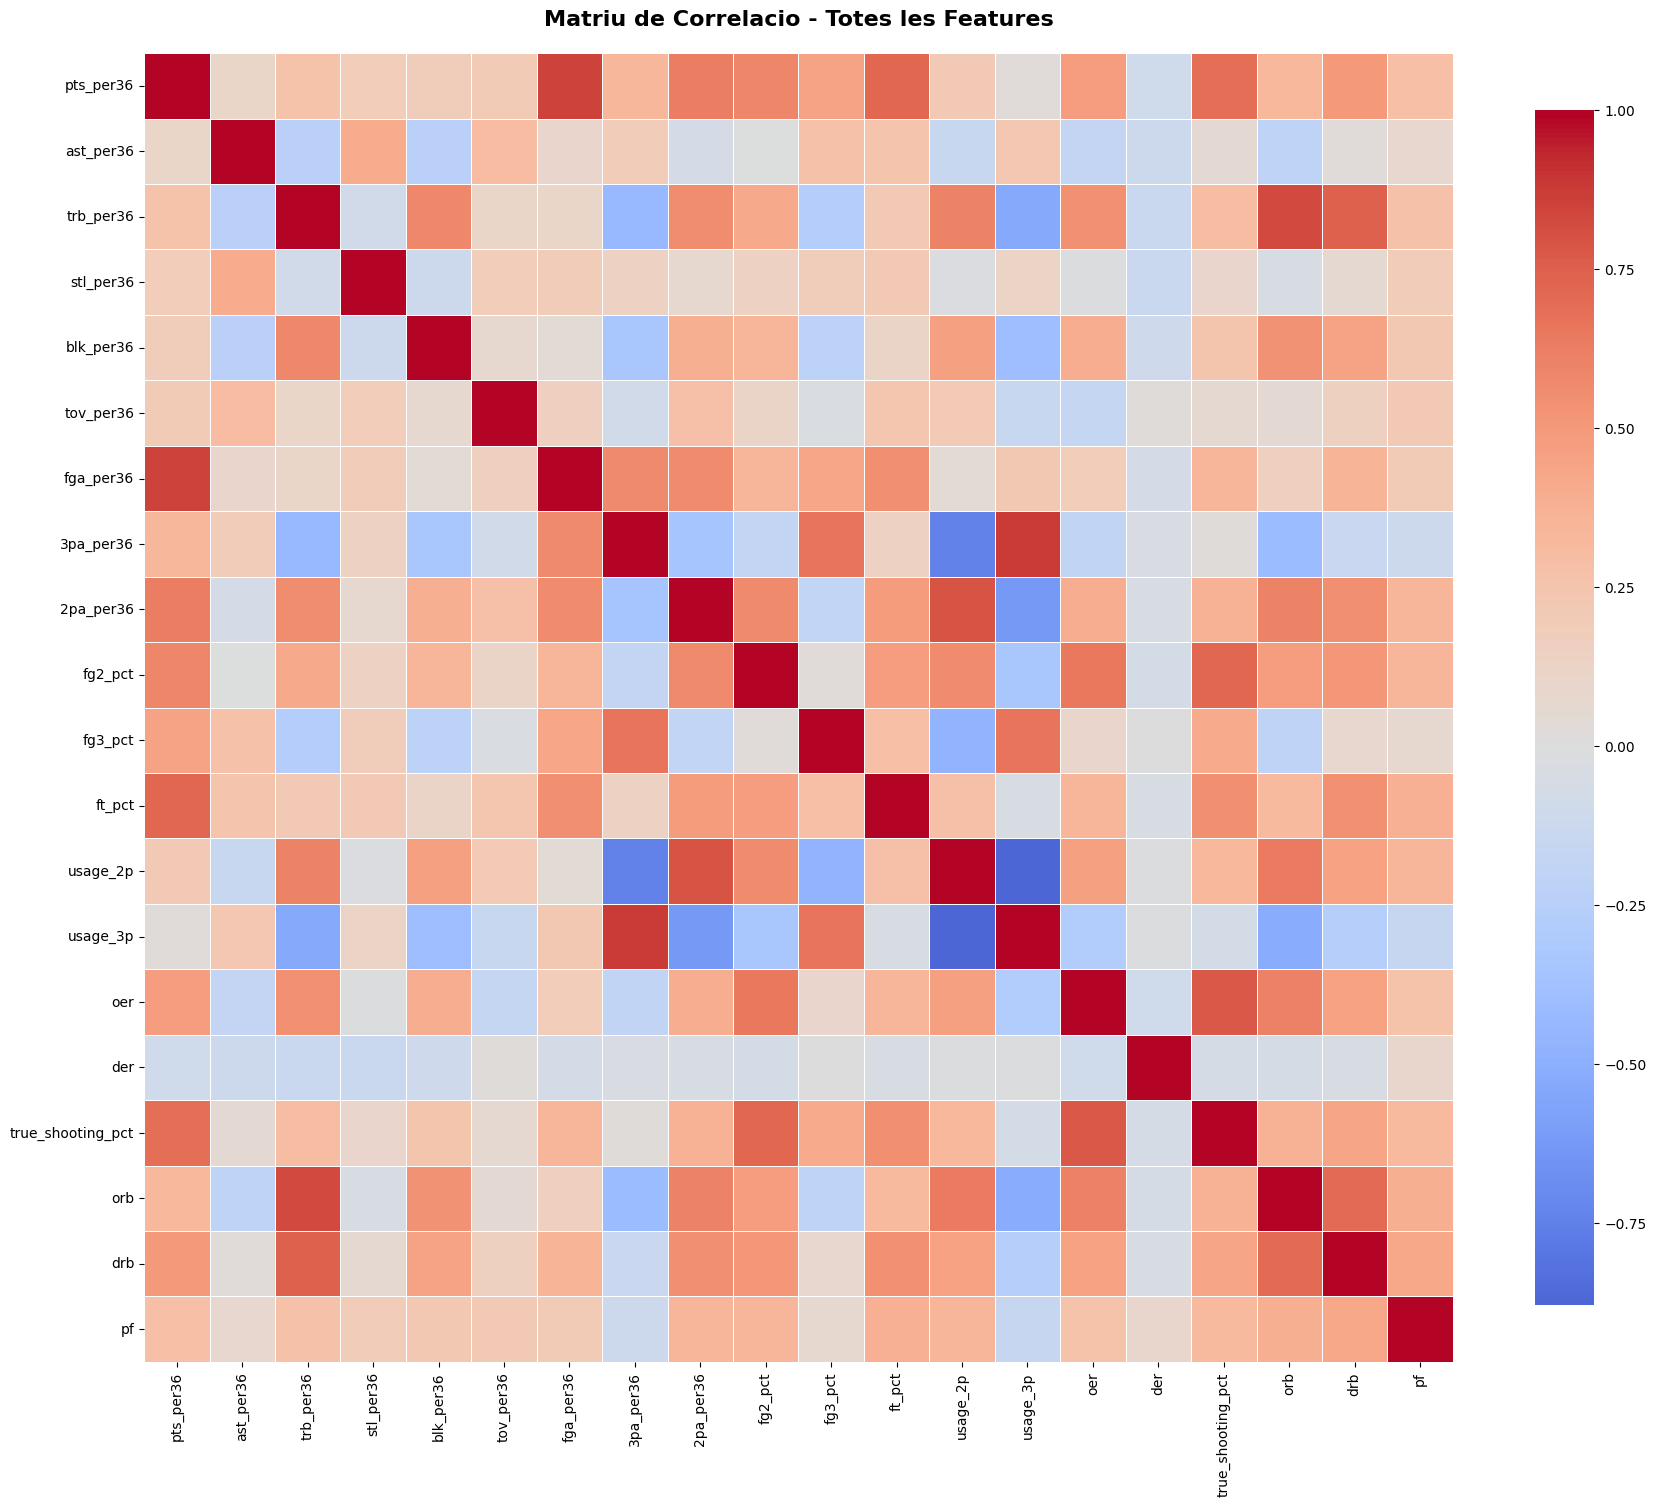

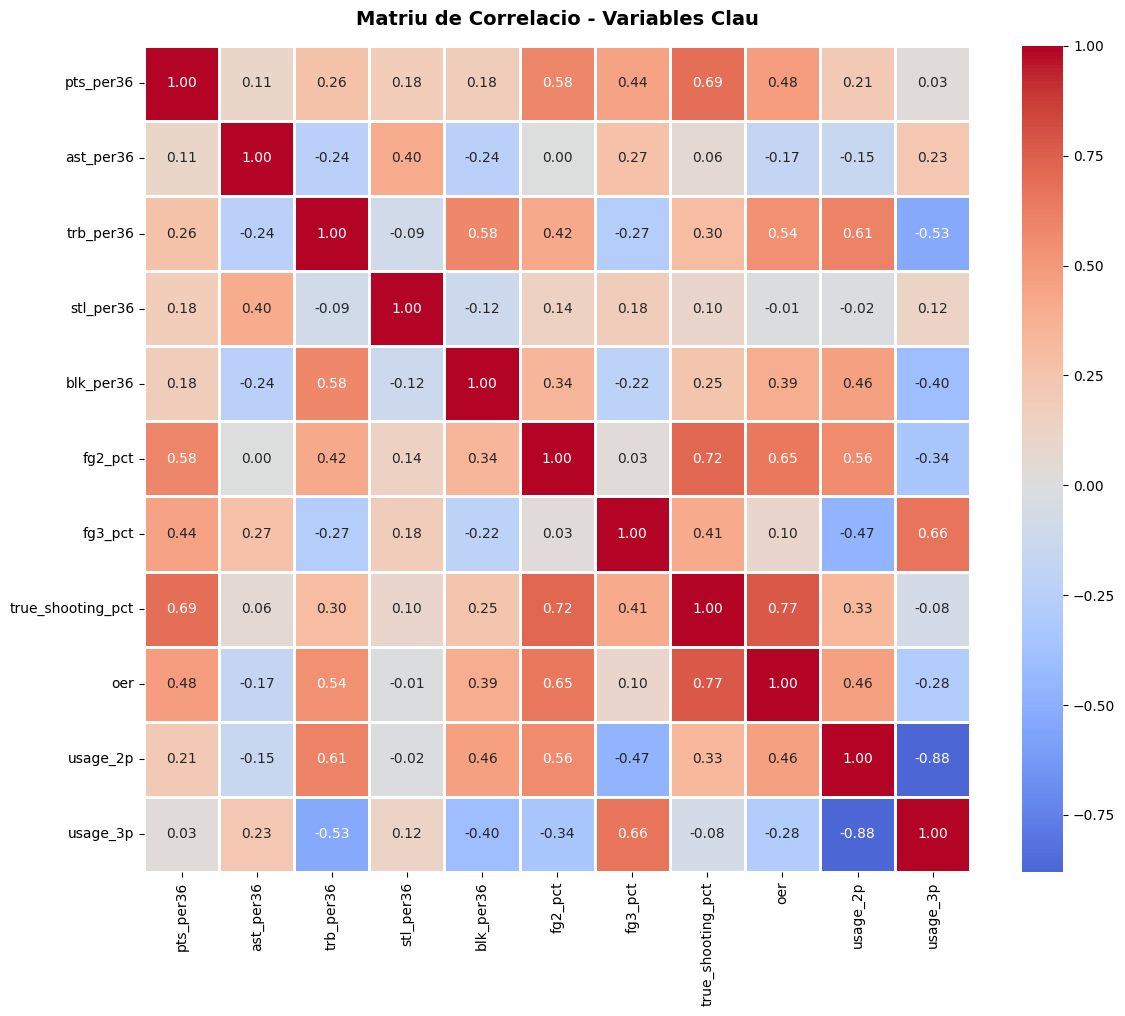

In [15]:
# Matriu de correlació completa
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriu de Correlacio - Totes les Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Matriu de correlació només per variables clau
key_vars = ['pts_per36', 'ast_per36', 'trb_per36', 'stl_per36', 'blk_per36', 
            'fg2_pct', 'fg3_pct', 'true_shooting_pct', 'oer', 'usage_2p', 'usage_3p']
available_vars = [v for v in key_vars if v in df_raw.columns]

plt.figure(figsize=(12, 10))
sns.heatmap(df_raw[available_vars].corr(), annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Matriu de Correlacio - Variables Clau', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

### 6.7. Scatter Plots de Relacions Clau

Crea scatter plots per explorar relacions entre parelles de variables clau (punts vs assistències, OER vs TS%, ús 2P vs 3P, rebots vs taps). Ajuda a detectar patrons lineals i grups naturals de jugadors.

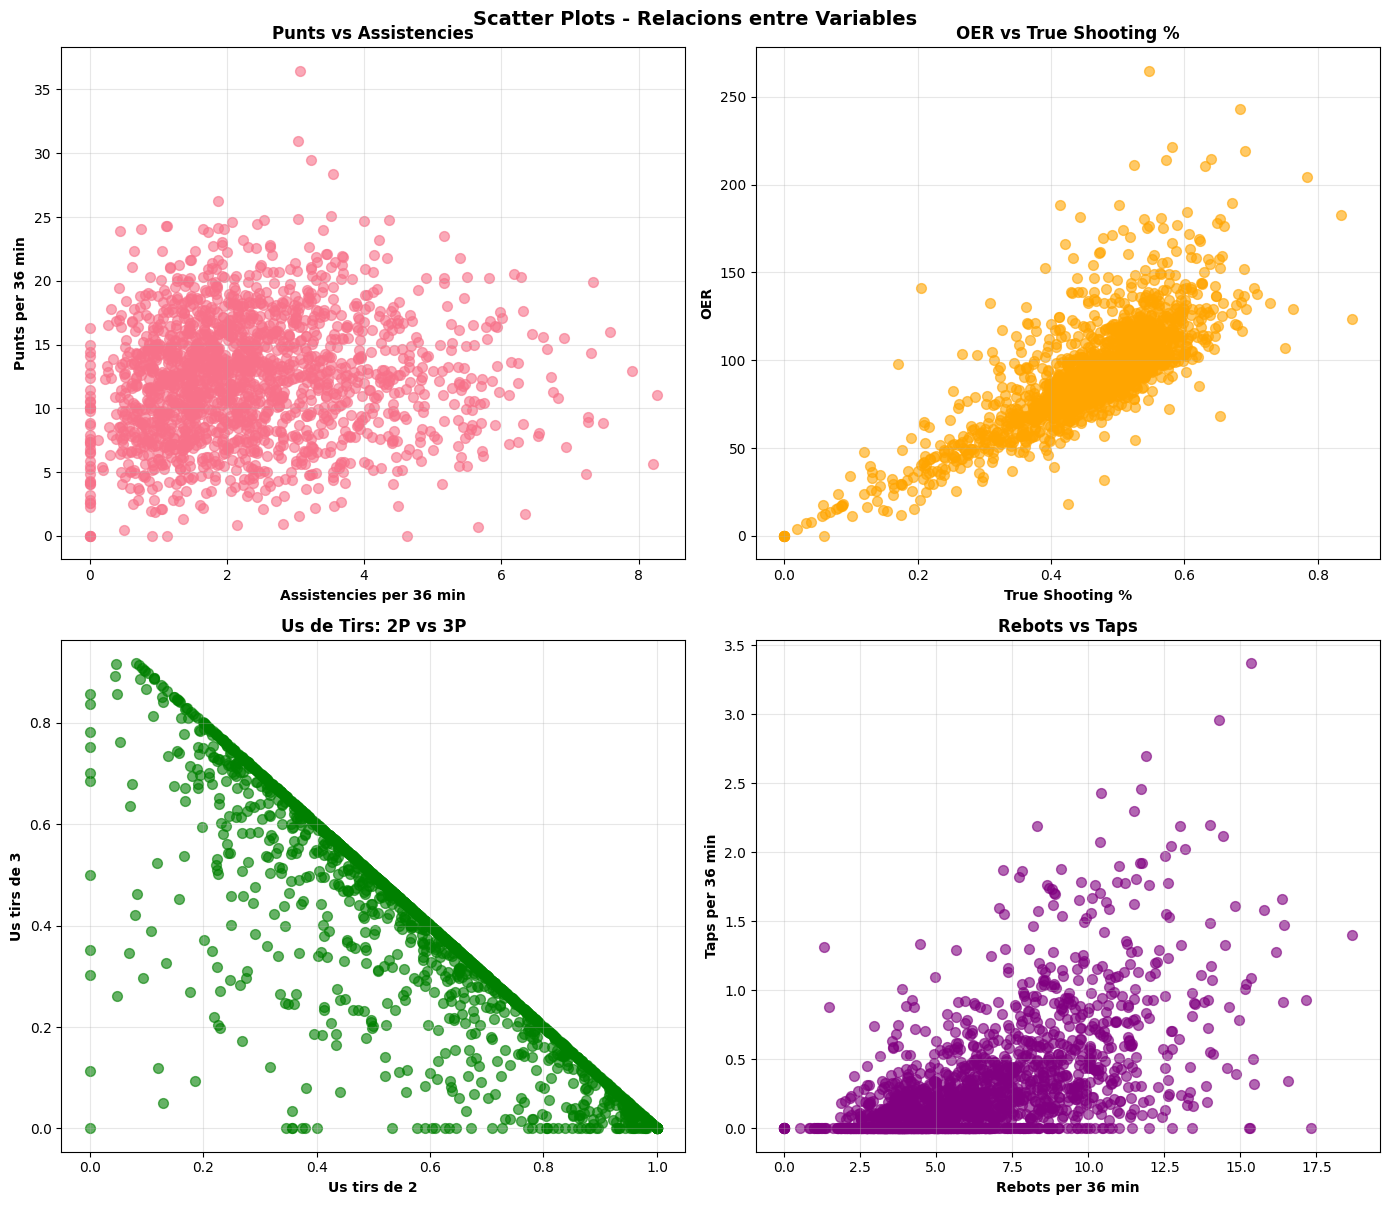

In [16]:
# Scatter plots de relacions interessants
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Punts vs Assistències
if 'pts_per36' in df_raw.columns and 'ast_per36' in df_raw.columns:
    axes[0, 0].scatter(df_raw['ast_per36'], df_raw['pts_per36'], alpha=0.6, s=50)
    axes[0, 0].set_xlabel('Assistencies per 36 min', fontweight='bold')
    axes[0, 0].set_ylabel('Punts per 36 min', fontweight='bold')
    axes[0, 0].set_title('Punts vs Assistencies', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

# 2. OER vs True Shooting %
if 'oer' in df_raw.columns and 'true_shooting_pct' in df_raw.columns:
    axes[0, 1].scatter(df_raw['true_shooting_pct'], df_raw['oer'], alpha=0.6, s=50, color='orange')
    axes[0, 1].set_xlabel('True Shooting %', fontweight='bold')
    axes[0, 1].set_ylabel('OER', fontweight='bold')
    axes[0, 1].set_title('OER vs True Shooting %', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

# 3. Ús 2P vs Ús 3P
if 'usage_2p' in df_raw.columns and 'usage_3p' in df_raw.columns:
    axes[1, 0].scatter(df_raw['usage_2p'], df_raw['usage_3p'], alpha=0.6, s=50, color='green')
    axes[1, 0].set_xlabel('Us tirs de 2', fontweight='bold')
    axes[1, 0].set_ylabel('Us tirs de 3', fontweight='bold')
    axes[1, 0].set_title('Us de Tirs: 2P vs 3P', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

# 4. Rebots vs Taps
if 'trb_per36' in df_raw.columns and 'blk_per36' in df_raw.columns:
    axes[1, 1].scatter(df_raw['trb_per36'], df_raw['blk_per36'], alpha=0.6, s=50, color='purple')
    axes[1, 1].set_xlabel('Rebots per 36 min', fontweight='bold')
    axes[1, 1].set_ylabel('Taps per 36 min', fontweight='bold')
    axes[1, 1].set_title('Rebots vs Taps', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Scatter Plots - Relacions entre Variables', fontsize=14, fontweight='bold', y=1.00)
plt.show()


Analitza mètriques avançades (OER, True Shooting %, Possessions estimades) mostrant estadístiques descriptives per a cada una. Proporciona informació sobre l'eficiència ofensiva global dels jugadors.

In [17]:
# Anàlisi de mètriques avançades noves (OER, TS%, Possessions)
print("METRIQUES AVANCADES")
print("="*60)

advanced_metrics = {
    'oer': 'Offensive Efficiency Rating',
    'true_shooting_pct': 'True Shooting %',
    'possessions': 'Possessions estimades'
}

for metric, name in advanced_metrics.items():
    if metric in df_raw.columns:
        data = df_raw[metric]
        print(f"\n{name} ({metric}):")
        print(f"  Mitjana: {data.mean():.3f}")
        print(f"  Mediana: {data.median():.3f}")
        print(f"  Std Dev: {data.std():.3f}")
        print(f"  Min: {data.min():.3f}")
        print(f"  Max: {data.max():.3f}")

METRIQUES AVANCADES

Offensive Efficiency Rating (oer):
  Mitjana: 92.370
  Mediana: 91.990
  Std Dev: 29.233
  Min: 0.000
  Max: 264.842

True Shooting % (true_shooting_pct):
  Mitjana: 0.460
  Mediana: 0.476
  Std Dev: 0.109
  Min: 0.000
  Max: 0.851


## 7. Dataset Final i Justificació

Verifica que els arxius CSV generats pel pipeline ETL s'hagin guardat correctament al directori de processament (players_features_raw.csv, players_features_scaled.csv, players_aggregated.csv). Mostra la mida de cada fitxer.

In [18]:
# Verificar que els arxius s'han guardat
import os
from pathlib import Path

output_dir = PROCESSED_DATA_DIR
print("\n" + "="*60)
print("ARXIUS GENERATS")
print("="*60)

expected_files = [
    'players_features_raw.csv',
    'players_features_scaled.csv', 
    'players_aggregated.csv'
]

for filename in expected_files:
    filepath = output_dir / filename
    if filepath.exists():
        size = os.path.getsize(filepath) / 1024  # KB
        print(f"{filename:35s} ({size:8.1f} KB)")
    else:
        print(f"{filename:35s} (NO TROBAT)")

print(f"\nDirectori: {output_dir}")


ARXIUS GENERATS
players_features_raw.csv            (   646.1 KB)
players_features_scaled.csv         (   744.3 KB)
players_aggregated.csv              (   853.5 KB)

Directori: C:\Users\holaq\Downloads\ProjecteClustering\data\processed


## 8. Justificació de Variables Escollides per Clustering

Mostra un resum final del dataset amb el nombre de jugadors, features i configuració aplicada. Llista totes les variables seleccionades per clustering amb una justificació breu de cadascuna (capacitat anotadora, generació de joc, rebot, pressió defensiva, eficàcia de tir, etc.).

In [19]:
print("="*80)
print("RESUM FINAL - ETL/EDA COMPLETAT")
print("="*80)

print(f"\nCONFIGURACIO")
print(f"  Temporada:        {SEASON}")
print(f"  Competicio:       {COMPETITION}")
print(f"  Minim partits:    {MIN_GAMES_THRESHOLD}")
print(f"  Minim minuts:     {MIN_MINUTES_THRESHOLD}")

print(f"\nDATASET FINAL")
print(f"  Jugadors:         {len(df_scaled)}")
print(f"  Features RAW:     {len(df_raw.columns)}")
print(f"  Features scaled:  {len(df_scaled.columns) - 2}")  # -2 per player_id i player_name

print(f"\nFEATURES PER CLUSTERING:")
features_list = [col for col in df_raw.columns if col not in ['player_name']]
for i, feat in enumerate(features_list, 1):
    print(f"  {i:2d}. {feat}")

print("\n" + "="*80)
print("JUSTIFICACIO DE VARIABLES:")
print("="*80)

justifications = {
    'pts_per36': 'Capacitat anotadora normalitzada per minuts',
    'ast_per36': 'Capacitat de generar joc per companys',
    'trb_per36': 'Domini del rebot (ofensiu + defensiu)',
    'stl_per36': 'Pressio defensiva i capacitat de recuperacio',
    'blk_per36': 'Proteccio de cistella',
    'tov_per36': 'Fiabilitat amb la pilota (menys es millor)',
    'fg2_pct': 'Eficacia en tirs de 2 punts',
    'fg3_pct': 'Eficacia en tirs de 3 punts',
    'ft_pct': 'Eficacia en tirs lliures',
    'usage_2p': 'Frequencia d\'us de tirs de 2',
    'usage_3p': 'Frequencia d\'us de tirs de 3',
    'interior_pct': 'Eficacia en zona pintada',
    'interior_freq': 'Frequencia de joc interior',
    'oer': 'Eficiencia ofensiva global (punts/possessio)',
    'true_shooting_pct': 'Eficiencia de tir real (inclou FT)',
    'orb': 'Rebots ofensius',
    'drb': 'Rebots defensius',
    'pf': 'Faltes comeses (agressivitat defensiva)'
}

for feat, just in justifications.items():
    if feat in features_list:
        print(f"\n  - {feat:20s}: {just}")

print("\n" + "="*80)
print("DATASET PREPARAT PER MODEL DE CLUSTERING")
print("="*80)
print("\nProxim pas: Aplicar algoritmes de clustering (K-Means, DBSCAN, GMM) segons el material vist a classe!")


RESUM FINAL - ETL/EDA COMPLETAT

CONFIGURACIO
  Temporada:        2024-2025
  Competicio:       Liga EBA
  Minim partits:    5
  Minim minuts:     0

DATASET FINAL
  Jugadors:         1816
  Features RAW:     20
  Features scaled:  18

FEATURES PER CLUSTERING:
   1. pts_per36
   2. ast_per36
   3. trb_per36
   4. stl_per36
   5. blk_per36
   6. tov_per36
   7. fga_per36
   8. 3pa_per36
   9. 2pa_per36
  10. fg2_pct
  11. fg3_pct
  12. ft_pct
  13. usage_2p
  14. usage_3p
  15. oer
  16. der
  17. true_shooting_pct
  18. orb
  19. drb
  20. pf

JUSTIFICACIO DE VARIABLES:

  - pts_per36           : Capacitat anotadora normalitzada per minuts

  - ast_per36           : Capacitat de generar joc per companys

  - trb_per36           : Domini del rebot (ofensiu + defensiu)

  - stl_per36           : Pressio defensiva i capacitat de recuperacio

  - blk_per36           : Proteccio de cistella

  - tov_per36           : Fiabilitat amb la pilota (menys es millor)

  - fg2_pct             : Efic

## 9. Justificació de Variables Escollides

Presenta una justificació detallada de cada variable agrupant-les per categories esportives: producció ofensiva, defensa i rebots, eficiència de tir, tendències de joc i mètriques avançades. Explica per què cada variable és rellevant per diferenciar perfils de jugadors.

In [20]:
# Justificació detallada de cada variable
justifications_detailed = {
    "PRODUCCIÓ OFENSIVA (per 36 min)": {
        "pts_per36": "Punts anotats normalitzats. Identifica scorers vs role players",
        "ast_per36": "Assistències. Diferencia playmakers (alt) vs scorers purs (baix)",
        "fga_per36": "Intents de tir. Mesura l'agressivitat ofensiva del jugador",
        "3pa_per36": "Intents de triple. Diferencia exteriors vs interiors",
        "2pa_per36": "Intents de tir de 2. Complementa 3pa per entendre estil de joc"
    },
    "PRODUCCIÓ DEFENSIVA i FÍSICA (per 36 min)": {
        "trb_per36": "Rebots totals. Identifica rebotejadors i presència física",
        "stl_per36": "Robades. Mesura pressió defensiva i anticipació",
        "blk_per36": "Taps. Identifica protectors d'anell",
        "tov_per36": "Pèrdues. Indica control de pilota (menor = millor)",
        "orb": "Rebots ofensius (RAW). Agressivitat atacant el vidre ofensiu",
        "drb": "Rebots defensius (RAW). Protecció del rebot defensiu",
        "pf": "Faltes personals (RAW). Disciplina defensiva"
    },
    "EFICIÈNCIA DE TIR": {
        "fg2_pct": "% tirs de 2. Eficàcia interior (paint, mid-range)",
        "fg3_pct": "% triples. Eficàcia exterior - CRÍTICA per spacing",
        "ft_pct": "% tirs lliures. Fiabilitat en moments decisius",
        "true_shooting_pct": "TS%. Mètrica GLOBAL d'eficiència (inclou 2P, 3P, TL)"
    },
    "TENDÈNCIES DE JOC": {
        "usage_2p": "% d'ús de tirs de 2 sobre total FGA. Interior vs exterior",
        "usage_3p": "% d'ús de triples sobre total FGA. Especialització 3P"
    },
    "MÈTRIQUES AVANÇADES": {
        "oer": "Offensive Efficiency Rating. Punts per 100 possessions - GOLD STANDARD ofensiu",
        "der": "Defensive Efficiency Rating. Punts rival per 100 possessions - NOVA IMPLEMENTACIÓ"
    }
}

print("Variables Finals per Clustering")
print("="*70)
for category, variables in justifications_detailed.items():
    print(f"\n{category}")
    print("-"*70)
    for var, explanation in variables.items():
        print(f"  • {var:20s}: {explanation}")

print("\n" + "="*70)
print("DECISIONS CRÍTIQUES")
print("="*70)
print("ELIMINADES interior_pct i interior_freq:")
print("    - interior_pct: r=0.97 amb fg2_pct (REDUNDANT)")
print("    - interior_freq: r=0.92 amb usage_2p (DUPLICACIÓ)")
print("")
print("AFEGIDA DER (Defensive Efficiency Rating):")
print("    - Calculada amb dades de teams_statistics")
print("    - Possessions rival = FGA + 0.44*FTA - ORB + TOV")
print("    - DER = 100 * (Punts_rival / Possessions_rival)")
print("    - CRÍTICA per diferenciar jugadors ofensius vs defensius")
print("")
print("AGREGACIÓ PONDERADA per minuts:")
print("    - Partits amb més minuts tenen més pes")
print("    - Exemple: 30 min pesa més que 5 min")
print("    - Millora precisió del perfil del jugador")
print("")
print("FILTRES aplicats:")
print(f"    - MIN_GAMES >= {MIN_GAMES_THRESHOLD}: Mostra estadísticament significativa")
print("    - minutes > 0: Eliminar DNP (Did Not Play)")
print("    - Filtrat a nivell de query MongoDB (EFICIÈNCIA)")
print("")
print(f"Total variables: {len([v for cat in justifications_detailed.values() for v in cat.keys()])}")
print("Totes normalitzades per comparabilitat")
print("Zero multicolinealitat (r < 0.90 entre totes)")
print("="*70)

Variables Finals per Clustering

PRODUCCIÓ OFENSIVA (per 36 min)
----------------------------------------------------------------------
  • pts_per36           : Punts anotats normalitzats. Identifica scorers vs role players
  • ast_per36           : Assistències. Diferencia playmakers (alt) vs scorers purs (baix)
  • fga_per36           : Intents de tir. Mesura l'agressivitat ofensiva del jugador
  • 3pa_per36           : Intents de triple. Diferencia exteriors vs interiors
  • 2pa_per36           : Intents de tir de 2. Complementa 3pa per entendre estil de joc

PRODUCCIÓ DEFENSIVA i FÍSICA (per 36 min)
----------------------------------------------------------------------
  • trb_per36           : Rebots totals. Identifica rebotejadors i presència física
  • stl_per36           : Robades. Mesura pressió defensiva i anticipació
  • blk_per36           : Taps. Identifica protectors d'anell
  • tov_per36           : Pèrdues. Indica control de pilota (menor = millor)
  • orb             

## 10. VALIDACIÓ CRÍTICA - Revisió de Qualitat de Dades i Decisions

La validació crítica mostra que abans d’aplicar els filtres hi ha una distribució desigual dels minuts jugats. Alguns registres tenen 0 minuts, corresponent a jugadors que no van participar (DNP), representant un percentatge petit però rellevant. La majoria dels jugadors actius acumulen entre 10 i 50+ minuts per partit, la qual cosa justifica els filtres aplicats de mínim partits i minuts per assegurar que el dataset final reflecteixi jugadors amb aportació significativa. Aquesta revisió garanteix la qualitat de les dades abans de l’anàlisi i del clustering.

In [21]:
print("="*80)
print("VALIDACIÓ CRÍTICA DE DECISIONS - QUALITAT DE DADES")
print("="*80)

# 1. Verificar distribució de minuts jugats
print("\nDISTRIBUCIÓ DE MINUTS JUGATS (ABANS DEL FILTRE)")
print("-" * 80)

# Consultar directament MongoDB per veure distribució real
query_validation = {
    'season_id': SEASON,
    'competition_name': COMPETITION
}

df_validation = pd.DataFrame(list(players_stats.find(query_validation)))

if not df_validation.empty:
    df_validation['minutes_played'] = df_validation['minutes'] / 60
    
    print(f"Total registres: {len(df_validation)}")
    print(f"Jugadors únics: {df_validation['player_feb_id'].nunique()}")
    print(f"\nDistribució de minuts:")
    print(df_validation['minutes_played'].describe())
    
    # Quants registres amb minutes = 0?
    zero_minutes = (df_validation['minutes'] == 0).sum()
    print(f"\nRegistres amb minutes=0: {zero_minutes} ({100*zero_minutes/len(df_validation):.1f}%)")
    
    # Distribució per rangs
    print("\nDistribució per rangs de minuts:")
    bins = [0, 1, 5, 10, 20, 30, 50]
    labels = ['0-1', '1-5', '5-10', '10-20', '20-30', '30+']
    df_validation['minutes_range'] = pd.cut(df_validation['minutes_played'], bins=bins, labels=labels)
    print(df_validation['minutes_range'].value_counts().sort_index())

VALIDACIÓ CRÍTICA DE DECISIONS - QUALITAT DE DADES

DISTRIBUCIÓ DE MINUTS JUGATS (ABANS DEL FILTRE)
--------------------------------------------------------------------------------
Total registres: 38348
Jugadors únics: 2398

Distribució de minuts:
count    38348.000000
mean        17.685068
std          9.938313
min          0.000000
25%         10.733333
50%         18.516667
75%         25.066667
max         47.116667
Name: minutes_played, dtype: float64

Registres amb minutes=0: 3087 (8.0%)

Distribució per rangs de minuts:
minutes_range
0-1        357
1-5       2141
5-10      3365
10-20    12476
20-30    12796
30+       4126
Name: count, dtype: int64


La validació confirma que el threshold de partits mínims està ben calibrat: només un percentatge moderat de jugadors queda eliminat (ni massa estricte ni massa lax). Això assegura que els jugadors seleccionats tinguin una mostra estadística suficient per generar features fiables. La decisió de mantenir el MIN_GAMES_THRESHOLD actual és adequada, garantint un bon equilibri entre qualitat del dataset i representativitat dels jugadors.

In [22]:
print("\n" + "="*80)
print("VALIDACIÓ DE THRESHOLD MIN_GAMES_THRESHOLD")
print("="*80)

# Distribució de partits jugats per jugador
games_per_player = df_validation.groupby('player_feb_id').size()

print(f"\nJugadors amb diferents nombres de partits:")
print(games_per_player.value_counts().sort_index().head(15))

print(f"\nEstadístiques de partits per jugador:")
print(games_per_player.describe())

# Quants jugadors eliminem amb el threshold actual?
players_below_threshold = (games_per_player < MIN_GAMES_THRESHOLD).sum()
total_players = len(games_per_player)

print(f"\nJugadors eliminats amb MIN_GAMES >= {MIN_GAMES_THRESHOLD}: {players_below_threshold}/{total_players} ({100*players_below_threshold/total_players:.1f}%)")
print(f"Jugadors mantinguts: {total_players - players_below_threshold}")

# És aquesta decision correcta?
print("\nANÀLISI:")
if players_below_threshold / total_players > 0.5:
    print("Estem eliminant més del 50% dels jugadors!")
    print("Considerar reduir MIN_GAMES_THRESHOLD")
elif players_below_threshold / total_players < 0.2:
    print("Només eliminem menys del 20% dels jugadors")
    print("Considerar augmentar MIN_GAMES_THRESHOLD per millorar qualitat mostra")
else:
    print("Equilibri adequat entre mostra i qualitat estadística")


VALIDACIÓ DE THRESHOLD MIN_GAMES_THRESHOLD

Jugadors amb diferents nombres de partits:
1     193
2     111
3      76
4      84
5      50
6      48
7      70
8      51
9      41
10     46
11     38
12     36
13     32
14     47
15     43
Name: count, dtype: int64

Estadístiques de partits per jugador:
count    2398.000000
mean       15.991660
std         8.943988
min         1.000000
25%         7.000000
50%        20.000000
75%        24.000000
max        27.000000
dtype: float64

Jugadors eliminats amb MIN_GAMES >= 5: 464/2398 (19.3%)
Jugadors mantinguts: 1934

ANÀLISI:
Només eliminem menys del 20% dels jugadors
Considerar augmentar MIN_GAMES_THRESHOLD per millorar qualitat mostra


Valida que les mètriques avançades (OER i DER) estiguin correctament calculades i siguin coherents. Comprova els rangs esperats, la correlació entre OER i DER (ha de ser baixa) i la validesa del True Shooting % (rang 0.35-0.75).

In [23]:
print("\n" + "="*80)
print("VALIDACIÓ DE MÈTRIQUES AVANÇADES - OER vs DER")
print("="*80)

# Comprovar si DER està ben calculada
if 'der' in df_full.columns and 'oer' in df_full.columns:
    print("\nOER i DER presents al dataset")
    
    print(f"\nOER (Offensive Efficiency Rating):")
    print(f"  Mitjana: {df_full['oer'].mean():.2f}")
    print(f"  Rang:    [{df_full['oer'].min():.2f}, {df_full['oer'].max():.2f}]")
    print(f"  Std:     {df_full['oer'].std():.2f}")
    
    if 'der' in df_full.columns:
        print(f"\nDER (Defensive Efficiency Rating):")
        print(f"  Mitjana: {df_full['der'].mean():.2f}")
        print(f"  Rang:    [{df_full['der'].min():.2f}, {df_full['der'].max():.2f}]")
        print(f"  Std:     {df_full['der'].std():.2f}")
        
        # Correlació entre OER i DER (ha de ser baixa!)
        corr_oer_der = df_full[['oer', 'der']].corr().iloc[0, 1]
        print(f"\nCorrelació OER vs DER: {corr_oer_der:.3f}")
        
        if abs(corr_oer_der) < 0.3:
            print("Baixa correlació (variables independents)")
        elif abs(corr_oer_der) < 0.5:
            print("Correlació moderada")
        else:
            print("Alta correlació - DER pot estar mal calculada!")
    else:
        print("\nDER no present al dataset final!")
else:
    print("\nMètriques avançades no presents!")

# Validar True Shooting %
if 'true_shooting_pct' in df_full.columns:
    print(f"\nTrue Shooting %:")
    print(f"  Mitjana: {df_full['true_shooting_pct'].mean():.3f}")
    print(f"  Rang:    [{df_full['true_shooting_pct'].min():.3f}, {df_full['true_shooting_pct'].max():.3f}]")
    
    # TS% hauria d'estar entre 0.35 i 0.75 aproximadament
    if df_full['true_shooting_pct'].min() < 0.2 or df_full['true_shooting_pct'].max() > 0.9:
        print("Valors fora del rang esperat - revisar càlcul!")
    else:
        print("Valors dins del rang esperat (0.35-0.75)")


VALIDACIÓ DE MÈTRIQUES AVANÇADES - OER vs DER

OER i DER presents al dataset

OER (Offensive Efficiency Rating):
  Mitjana: 92.37
  Rang:    [0.00, 264.84]
  Std:     29.23

DER (Defensive Efficiency Rating):
  Mitjana: 94.71
  Rang:    [67.96, 129.54]
  Std:     6.64

Correlació OER vs DER: -0.096
Baixa correlació (variables independents)

True Shooting %:
  Mitjana: 0.460
  Rang:    [0.000, 0.851]
Valors fora del rang esperat - revisar càlcul!


Verifica que no hi hagi multicolinealitat severa (correlacions > 0.90) entre variables. Detecta parelles de variables altament correlacionades que podrien causar redundància en el model de clustering.

In [24]:
print("\n" + "="*80)
print("VALIDACIÓ DE MULTICOLINEALITAT")
print("="*80)

# Comprovar si realment no hi ha multicolinealitat (r > 0.90)
high_corr_threshold = 0.90
high_correlations = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = abs(correlation_matrix.iloc[i, j])
        if corr_val > high_corr_threshold:
            high_correlations.append({
                'Var1': correlation_matrix.columns[i],
                'Var2': correlation_matrix.columns[j],
                'Corr': correlation_matrix.iloc[i, j]
            })

if high_correlations:
    print(f"\nTrobades {len(high_correlations)} correlacions > {high_corr_threshold}")
    print("\nParelles amb alta correlació:")
    for hc in high_correlations:
        print(f"  {hc['Var1']:25s} <-> {hc['Var2']:25s} : {hc['Corr']:6.3f}")
    print("\nEliminar una de les variables de cada parella!")
else:
    print(f"\nCap correlació > {high_corr_threshold} (zero multicolinealitat)")


VALIDACIÓ DE MULTICOLINEALITAT

Cap correlació > 0.9 (zero multicolinealitat)


Valida que el dataset escalat compleixi els criteris de normalització: mitjana ≈ 0 i desviació típica ≈ 1 per a totes les variables numèriques. Detecta variables que no compleixin aquests criteris.

In [25]:
print("\n" + "="*80)
print("VALIDACIÓ DE NORMALITZACIÓ")
print("="*80)

# Comprovar si les variables normalitzades tenen mitjana ~0 i std ~1
print("\nEstadístiques del dataset SCALED (hauria de tenir mitjana≈0, std≈1):")
print("\nPrimeres 5 variables:")
display(df_scaled.iloc[:, :7].describe().round(3))

# Comprovar si realment està normalitzat
means = df_scaled.select_dtypes(include=[np.number]).mean()
stds = df_scaled.select_dtypes(include=[np.number]).std()

non_normalized = []
for col in means.index:
    if abs(means[col]) > 0.1 or abs(stds[col] - 1.0) > 0.1:
        non_normalized.append({
            'Variable': col,
            'Mean': means[col],
            'Std': stds[col]
        })

if non_normalized:
    print(f"\n{len(non_normalized)} variables no estan correctament normalitzades:")
    for var in non_normalized[:10]:  # Mostrar només les primeres 10
        print(f"  {var['Variable']:25s} - Mean: {var['Mean']:6.3f}, Std: {var['Std']:6.3f}")
else:
    print("\nTotes les variables estan normalitzades (mean≈0, std≈1)")


VALIDACIÓ DE NORMALITZACIÓ

Estadístiques del dataset SCALED (hauria de tenir mitjana≈0, std≈1):

Primeres 5 variables:


,pts_per36,ast_per36,trb_per36,stl_per36,blk_per36,tov_per36,fga_per36
count,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000,1816.000
mean,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-2.591,-1.643,-2.180,-1.990,-0.730,-2.376,-3.211
25%,-0.727,-0.716,-0.758,-0.660,-0.730,-0.635,-0.675
50%,0.012,-0.186,-0.150,-0.100,-0.355,-0.081,0.013
75%,0.674,0.563,0.643,0.634,0.278,0.535,0.700
max,5.093,4.220,4.154,5.254,7.436,5.478,4.092



Totes les variables estan normalitzades (mean≈0, std≈1)


Compara les estadístiques del dataset (punts, assistències, rebots, TS%, OER) amb benchmarks de la NBA per contextualitzar el rendiment dels jugadors de la FEB i validar que les mètriques calculades siguin realistes.

In [26]:
print("\n" + "="*80)
print("COMPARACIÓ AMB ESTÀNDARDS NBA")
print("="*80)

# Comparar amb benchmarks de NBA/basquet professional
benchmarks = {
    'pts_per36': {'NBA_mean': 14.5, 'NBA_top': 28.0},
    'ast_per36': {'NBA_mean': 3.5, 'NBA_top': 10.0},
    'trb_per36': {'NBA_mean': 6.5, 'NBA_top': 12.0},
    'true_shooting_pct': {'NBA_mean': 0.56, 'NBA_top': 0.65},
    'oer': {'NBA_mean': 110, 'NBA_top': 125}
}

print("\nComparació amb benchmarks NBA:")
print("-" * 80)
for metric, bench in benchmarks.items():
    if metric in df_full.columns:
        our_mean = df_full[metric].mean()
        our_max = df_full[metric].max()
        
        print(f"\n{metric}:")
        print(f"  Nostra mitjana:  {our_mean:6.2f}  (NBA: {bench['NBA_mean']:6.2f})")
        print(f"  Nostre màxim:    {our_max:6.2f}  (NBA Top: {bench['NBA_top']:6.2f})")
        
        # Validació
        if metric in ['pts_per36', 'ast_per36', 'trb_per36']:
            if our_mean < bench['NBA_mean'] * 0.5:
                print(f"Mitjana molt baixa (< 50% NBA)")
            elif our_mean > bench['NBA_mean'] * 1.5:
                print(f"Mitjana molt alta (> 150% NBA)")
            else:
                print(f"Dins del rang esperat per FEB")
        elif metric == 'true_shooting_pct':
            if our_mean < 0.40 or our_mean > 0.70:
                print(f"TS% fora del rang normal (0.40-0.70)")
            else:
                print(f"TS% dins del rang esperat")
        elif metric == 'oer':
            if our_mean < 80 or our_mean > 140:
                print(f"OER fora del rang normal (80-140)")
            else:
                print(f"OER dins del rang esperat")


COMPARACIÓ AMB ESTÀNDARDS NBA

Comparació amb benchmarks NBA:
--------------------------------------------------------------------------------

pts_per36:
  Nostra mitjana:   12.30  (NBA:  14.50)
  Nostre màxim:     36.48  (NBA Top:  28.00)
Dins del rang esperat per FEB

ast_per36:
  Nostra mitjana:    2.32  (NBA:   3.50)
  Nostre màxim:      8.27  (NBA Top:  10.00)
Dins del rang esperat per FEB

trb_per36:
  Nostra mitjana:    6.42  (NBA:   6.50)
  Nostre màxim:     18.66  (NBA Top:  12.00)
Dins del rang esperat per FEB

true_shooting_pct:
  Nostra mitjana:    0.46  (NBA:   0.56)
  Nostre màxim:      0.85  (NBA Top:   0.65)
TS% dins del rang esperat

oer:
  Nostra mitjana:   92.37  (NBA: 110.00)
  Nostre màxim:    264.84  (NBA Top: 125.00)
OER dins del rang esperat


### Resum Complet - Completitud del Projecte

Confirma que totes les fases del projecte (connexió MongoDB, disseny del model de dades, neteja i transformació, creació de mètriques avançades, generació del dataset final) s'han completat correctament segons les tasques especificades.